In [1]:
from SwaV import SwaV
from LSTMDownStream import SupervisedDownstream
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from lightly.loss import SwaVLoss
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
from lightly.models.modules.memory_bank import MemoryBankModule
from lightly.transforms.swav_transform import SwaVTransform
import pytorch_lightning as pl
import pandas as pd
import os
import numpy as np
from scipy import signal as sig
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import torch.nn.functional as F

Pre-train SwaV with some data

In [ ]:
a = get_iEEG_data(username = 'joie1',
                        password_bin_file = 'ieeglogin.bin',
                        iEEG_filename = file_name,
                        start_time_usec = window_start_time*1e6,
                        stop_time_usec = window_stop_time*1e6,
                        select_electrodes = select_channels)

In [5]:
a = data[0]
a = a.to_numpy().T

torch.Size([1170, 11750])


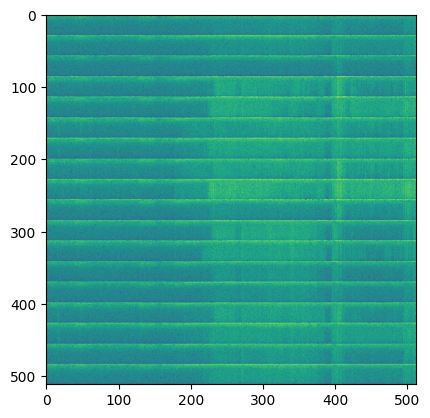

In [79]:
# Parameters
fs = 256
# List to store spectrograms of all channels
signal = a

def eeg_to_spectrogram(eeg_data, n_fft=128, hop_length=8, window=torch.hann_window):
    """
    Args:
        eeg_data (torch.Tensor): A tensor of shape (3, T) representing the EEG data.
        n_fft (int): The number of Fourier components (FFT window size).
        hop_length (int): The hop length for the STFT.
        window (callable): Window function to apply (default is Hann window).
    
    Returns:
        torch.Tensor: Spectrogram tensor of shape (3, frequency_bins, time_frames, 2) 
                      (where the last dimension represents the real and imaginary parts).
    """
    spectrograms = []
    for channel in eeg_data:
        # Perform STFT on each channel separately
        channel_spectrogram = torch.stft(channel, n_fft=n_fft, hop_length=hop_length, 
                                         window=window(n_fft), return_complex=False)
        spectrograms.append(channel_spectrogram)
    
    # Stack the spectrograms to have shape (3, frequency_bins, time_frames, 2)
    spectrograms = torch.vstack(spectrograms)
    return spectrograms

def magnitude_spectrogram(spectrogram):
    # Compute the magnitude of the complex values
    magnitude = torch.sqrt(spectrogram[..., 0]**2 + spectrogram[..., 1]**2)
    return magnitude

# Convert to magnitude spectrogram
magnitude_spec = magnitude_spectrogram(eeg_to_spectrogram(torch.tensor(signal,requires_grad=False)))
print(magnitude_spec.shape)
spec_resized = torch.log(F.interpolate(magnitude_spec.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='nearest'))

plt.imshow(spec_resized[0,0])
#remove 60 Hz  1-50 Hz
#we can try ResNet18 first 

In [77]:
spec_resized = spec_resized.squeeze(0).repeat(3,1,1)
spec_resized.shape

torch.Size([3, 512, 256])

In [ ]:
def transform(data):
    

In [106]:
class SwavDataset(Dataset):
    def __init__(self, root, label_file_root, transform, data_augmentation=False):
        self.data = []
        label_file = pd.read_pickle(label_file_root)
        labels = label_file.dropna()
        for id in labels['id']:
            dt = pd.read_pickle(root+id)
            self.data.append(dt)
        #self.data = pd.read_pickle(data_file)  # list(recording1, recording2, .....)
        self.data_augmentation = data_augmentation
        self.transform = transform  # transform function to spectrogram
        self.sampling_rate = 256
        self.sliding_window_size = 256

        self.per_recording_length = [int(np.floor(len(dt)/self.sliding_window_size)) for dt in self.data]
        self.cumulative_recording_lengths = np.cumsum(self.per_recording_length)

        self.compute_index_look_up_table()

        #self.augmentation = ...

    def __len__(self):
        return np.sum(self.per_recording_length)  # get the sum of maximum number of sliding windows from each recoding, for non-overlapping sliding windows

    def compute_index_look_up_table(self):
        # helper function to get the correct sliding window from the index
        # general idea, given some global index, find the correct recording from a list of recordings (your input data),
        # and find the correct slice from the correct recording
        index_look_up_table = {}
        for i in range(np.sum(self.per_recording_length)):
            # some implementation_here
            recording_idx = np.where(i<=self.cumulative_recording_lengths)[0][0]
            cumulative_recording_lengths_ = np.insert(self.cumulative_recording_lengths,0,0)
            within_recording_start_idx = (i-cumulative_recording_lengths_[recording_idx])*self.sliding_window_size
            within_recording_stop_idx = within_recording_start_idx+self.sliding_window_size
            index_look_up_table[i] = [recording_idx, within_recording_start_idx, within_recording_stop_idx]

        self.index_look_up_table = index_look_up_table

    def slice_helper(self, data, index):
        recording_idx, start_index, stop_index = self.index_look_up_table[index]
        recording = data[recording_idx]
        return recording[start_index:stop_index]

    def __getitem__(self, idx):

        data_clip = self.slice_helper(self.data, idx)

        if self.data_augmentation:
            data_clip = self.augmentation(data_clip)

        data_clip = self.transform(data_clip)
        
        # remember to convert to rgb image, resize to correct shape and to torch tensor

        return ToTensor(data_clip)  # output_shape : features * sliding_window_size for example (190*256)

In [107]:
model = SwaV()
def transform(data):
    data = data.to_numpy().T
    return (data- np.mean(data,axis=0))/np.std(data,axis=0)

swav_dataset = SwavDataset(root = '/home1/k/kuangzy/scalp_eeg/ScalpEEG_w_anns/', 
                           label_file_root = '/home1/k/kuangzy/scalp_eeg/ScalpEEG_w_anns/labels',
                           transform=transform,
                           data_augmentation = False)

dataloader = torch.utils.data.DataLoader(
    swav_dataset,
    batch_size=5,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(max_epochs=20, devices=1, accelerator=accelerator)
trainer.fit(model=model, train_dataloaders=dataloader)


/home1/k/kuangzy/.local/lib/python3.11/site-packages/lightly/models/modules/memory_bank.py:89: UserWarning: Memory bank size 'size=512' does not specify feature dimension. It is recommended to set the feature dimension with 'size=(n, dim)' when creating the memory bank. Distributed training might fail if the feature dimension is not set.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | backbone        | Sequential         | 23.5 M | train
1 | projection_head | SwaVProjectionHead | 4.5 M  | train
2 | prototypes      | SwaVPrototypes     | 264 K  | train
3 | queues          | ModuleList         | 0      | train
4 | criterion       | SwaVLoss           | 0      | train
---------------------------------------------------------------
28.2 M  

Epoch 0:   0%|          | 0/4518 [00:00<?, ?it/s] 

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home1/k/kuangzy/.local/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home1/k/kuangzy/.local/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home1/k/kuangzy/.local/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_42932/3864314544.py", line 56, in __getitem__
    return ToTensor(data_clip)  # output_shape : features * sliding_window_size for example (190*256)
           ^^^^^^^^^^^^^^^^^^^
TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given


In [ ]:
class LSTMDataset(Dataset):
    def __init__(self, data, label, data_augmentation=False):
        self.data = data  # list(recording1, recording2, .....)
        self.label = label
        self.data_augmentation = data_augmentation
        self.transform = ...  # transform function to spectrogram
        self.label_transform = ...  # transform function for labels
        self.sampling_rate = 256
        self.LSTM_max_length = 200
        self.sliding_window_size = 256
        self.segment_length = self.sliding_window_size * self.LSTM_max_length

        self.per_recording_length = np.ceil(
            int(np.floor([len(dt) / self.sliding_window_size for dt in self.data])) / self.LSTM_max_length)
        # because before, we are throwing away sliding windows that are less than 1 second, but now we want to PRESERVE short segments that is less than LSTM_max_length, again for non-overlapping short segments
        self.cumulative_recording_lengths = np.cumsum(self.per_recording_length)

        self.compute_index_look_up_table()

        self.augmentation = ...  # data augmentation function

    def __len__(self):
        return np.sum(self.per_recording_length)

    def compute_index_look_up_table(self):
        # similar as above, but this time find the correct segment
        # need to consider the less than edge cases of LSTM_max_length
        index_look_up_table = {}
        for i in range(np.sum(self.per_recording_length)):
            recording_idx = np.where(i<=self.cumulative_recording_lengths)[0][0]
            cumulative_recording_lengths_ = np.insert(self.cumulative_recording_lengths,0,0)
            within_recording_start_idx = (i-cumulative_recording_lengths_[recording_idx])*self.sliding_window_size
            within_recording_stop_idx = within_recording_start_idx+self.sliding_window_size
            if i == self.cumulative_recording_lengths[recording_idx]:
                within_recording_stop_idx = len(self.data[recording_idx])
            index_look_up_table[i] = [recording_idx, within_recording_start_idx, within_recording_stop_idx]

        self.index_look_up_table = index_look_up_table

    def slice_helper(self, data, index):
        recording_idx, start_index, stop_index = self.index_look_up_table[index]
        recording = data[recording_idx]
        segment = recording[start_index:stop_index]
        return segment.reshape(...)  # return size: length_of_segment * features * sliding_window_size

    def __getitem__(self, idx):
        data_segment = self.slice_helper(self.data, idx)

        if self.data_augmentation:
            data_segment = self.augmentation(data_segment)

        data_segment = self.transform(data_segment)
        label_segment = self.label_transform(self.label)


        # remember to convert to rgb image, resize to correct shape and to torch tensor

        # output_shape: data_segment =  length_of_segment * features * sliding_window_size
        # output_shape: label_segment =  length_of_segment

        return data_segment, label_segment.to(dtype=torch.long)


# to be called in dataloader, very important to handle variable length case
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    sequence_len = [dt.size(0) for dt in data]

    return torch.concat(data), torch.concat(label), sequence_len


# for dataloader
train_dataset = LSTMDataset(train_data, train_label, data_augmentation=False)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=16 # critical to performance, but each worker need its own RAM, so the memory usage will be 16 times the num_workers = 1S
)


In [14]:
# load the ResNet trained with SSL to use with LSTM for final prediction in this way
swav = SwaV.load_from_checkpoint(checkpoint_path='/home1/k/kuangzy/scalp-eeg-1/CNN-LSTM/lightning_logs/version_1/checkpoints/epoch=19-step=880.ckpt')
model = SupervisedDownstream(swav.backbone)
sd = SupervisedDownstream(model)
# ...